<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/Tensorflow_Keras/LSTM%20RNN/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Recurrent Neural Networks used as Generative models.



**Load the Libraries**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

**Download a free corpus of text that we can use to train text generative models**

Download the complete text of *Alice’s Adventures in Wonderland by Lewis Carroll* in ASCII format (Plain Text UTF-8) for free. Project Gutenberg adds a standard header and footer to each book and this is not part of the original text. Open the file in a text editor and delete the header and footer. Save it and load it as `wonderland.txt`.

**Load ascii text and covert to lowercase**

In [ ]:
filename = "wonderland.txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()

## Data Preprocessing

At first we will remove the 15 punctuations from the sequences

In [ ]:
punc_list = ['!', '"',"'",'(',')','*',',','-',':','.',';','?','[',']','_']
punc_rem_text =  ''.join(c for c in raw_text if c not in punc_list)

We prepare the Data for modeling by the neural network. We cannot model the characters directly, instead we must convert the characters to integers. We can do this easily by first creating a set of all of the distinct characters in the book, then creating a map of each character to a unique integer.

In [23]:
# create mapping of unique chars to integers
chars = sorted(list(set(punc_rem_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
char_to_int

{'\n': 0,
 ' ': 1,
 '0': 2,
 '3': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

Summarize the cleaned dataset

In [24]:
n_chars = len(punc_rem_text)
chars = sorted(list(set(punc_rem_text)))
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  136110
Total Vocab:  30


We split the book into sequences based on end of lines. We don't consider full sentences as the learning is based on character level and few sentenses are too long to introduce lot of sparsity in the model training.



In [ ]:
list_of_sen = punc_rem_text.split('\n')

We convert the characters to integers using our lookup table we prepared earlier.

In [ ]:
list_of_int=[]
for sen in list_of_sen:
  list_of_int.append([char_to_int[c] for c in sen])

We remove the unwanted empty sequences formed due to multiple ends between lines

In [ ]:
data_before = [x for x in list_of_int if x != []]

Summary of the length of sequences based on end of lines

In [28]:
j = [len(i) for i in data_before]
max(j), min(j), np.mean(j), np.median(j)

(73, 2, 53.515517936316, 63.0)

Text(0, 0.5, 'Probability')

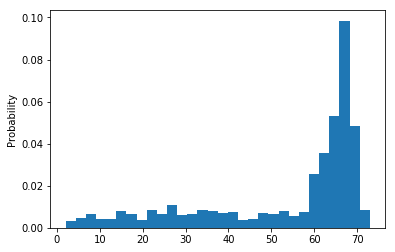

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(j), density=True, bins=30)
plt.ylabel('Probability')

We combine the sequences to form a final array.

In [ ]:
dataX_list = [ch for sublist in data_before for ch in sublist]

Prepare the dataset by creating padded sequences for every 63 words

In [12]:
#prepare the dataset of input to output pairs encoded as integers
from keras.preprocessing.sequence import pad_sequences

# Use a sequence length of 63 (median)
seq_length = 63
n_int = len(dataX_list)
dataX = []
dataY = []
count = 0
input_seq = []

# Run a for loop to fetch each sequence of length 63
for i in range(0, n_int, seq_length):
  seq_in = dataX_list[i:i + seq_length]
  
  # # Run through the entire sequence
  for j in range(0, len(seq_in)-1):
    count += 1
    
    # Create sub-sequences from length 1 to 100
    in_seq = seq_in[:j+1]
    out_seq = seq_in[j+1]
    
    # Append the sub-sequences together
    input_seq.append([int_ for int_ in in_seq])
    dataY.append(out_seq)

# Pad all the sequences to length 100, use pre-padding    
dataX = pad_sequences(input_seq, maxlen=seq_length, padding='pre')

n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  130953


In [13]:
dataX[1], dataY[1]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  4, 15], dtype=int32), 12)

* First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network.

* Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default.

* Finally, we need to convert the output patterns (single characters converted to integers) into a one hot encoding

In [ ]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))

# normalize
X = X / float(n_vocab)

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

## Model Training

In [15]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), dropout=0.1, return_sequences=True))
model.add(LSTM(256, dropout=0.1))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

W0728 02:55:45.176415 140255759828864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 02:55:45.216488 140255759828864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 02:55:45.225648 140255759828864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 02:55:45.456321 140255759828864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 02:55:45.471931 

There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence. You will see different results because of the stochastic nature of the model, and because it is hard to fix the random seed for LSTM models to get 100% reproducible results. This is not a concern for this generative model.

In [16]:
# define the checkpoint
checkpoint = ModelCheckpoint("model.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')

# Fit the Model to data
model.fit(X, y, epochs=100, batch_size=128, callbacks=[checkpoint])

W0728 02:55:46.353408 140255759828864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
130953/130953 [==============================] - 304s 2ms/step - loss: 2.7235

Epoch 00001: loss improved from inf to 2.72352, saving model to model.h5
Epoch 2/100
130953/130953 [==============================] - 300s 2ms/step - loss: 2.4065

Epoch 00002: loss improved from 2.72352 to 2.40651, saving model to model.h5
Epoch 3/100
130953/130953 [==============================] - 300s 2ms/step - loss: 2.2154

Epoch 00003: loss improved from 2.40651 to 2.21544, saving model to model.h5
Epoch 4/100
130953/130953 [==============================] - 300s 2ms/step - loss: 2.0974

Epoch 00004: loss improved from 2.21544 to 2.09736, saving model to model.h5
Epoch 5/100
130953/130953 [==============================] - 300s 2ms/step - loss: 2.0125

Epoch 00005: loss improved from 2.09736 to 2.01250, saving model to model.h5
Epoch 6/100
130953/130953 [==============================] - 300s 2ms/step - loss: 1.9458

Epoch 00006: loss improved from 2.01250 to 1.94583, saving model to model

## Generating Text with the trained LSTM Network

In [ ]:
# load the trained network
from keras.models import load_model
model = load_model('model.h5')

When preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [ ]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 500 characters in length).

In [19]:
# pick a random seed
import sys
start = np.random.randint(0, len(dataX)-1)
pattern = list(dataX[start])
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(500):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 




































































r if "
r eheaned iersenf dillgh of tuist sosrttoetha got to the thould ruarren i hrt the wroow littlebusw and temsvedistell the mike anotely iengral eo loto anices dlnsstear it taid the cames cheak followg of near the toodiersoo and alice lade oife thak drnesuion yhat took iis face and what if said to the tuiek and tuuetge satted iishast yordering toundny sfrulngoong sand yiat firtt anl touw of teyt tucceumat he said tu tay toeezing anicerulzes shruted the fouterst the whought anice tuondling hir vor f
Done.
